In [2]:
suppressPackageStartupMessages({
    library(harmony)
    library(uwot)
    library(singlecellmethods)
    library(sfarrow)
    library(geojsonsf)
    library(sf)    
    library(spatula)
    library(purrr)
    library(furrr)
    library(circlize)
    library(ComplexHeatmap)
    library(ggrepel)
    library(lme4)
    library(future)
    library(scales)
    library(glue)
    library(data.table)
    library(spatstat)
    library(dplyr)
    library(data.table)
    library(presto)
    library(ggplot2)
    library(ggthemes)
    library(patchwork)
    library(Matrix)
})

fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}

source('utils_plotting.R')
source('utils.R')


# Data

## geomx

In [2]:
geomx_df = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/geomx/genedataChenLab_exp2_for_Ilya.csv')[
    ROI_Type %in% c('hybrid hub', 'immunity hub')
][
    , `:=`(y = log2(q_norm), ROI_Type = factor(ROI_Type, c('immunity hub', 'hybrid hub')))
][]


In [3]:
head(geomx_df)

V1,FeatureName,SampleName,q_norm,Module,roi,ROI_Type,area,LOQ.Alpha_GeoMx_TCR_v1.1,LOQ.Hs_R_NGS_CTA_v1.0,⋯,NegGeoMean_Hs_R_NGS_CTA_v1.0,NegGeoSD_Hs_R_NGS_CTA_v1.0,NegGeoSD_Alpha_GeoMx_TCR_v1.1,NegGeoMean_Alpha_GeoMx_TCR_v1.1,GenesDetected,SegmentDiversity,ChainDiversity,snr,above_LOQ,y
<int>,<chr>,<chr>,<dbl>,<chr>,<int>,<fct>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
1,ACTA2,DSP-1001660013300-A-A02.dcc,105.04613,Hs_R_NGS_CTA_v1.0,1,hybrid hub,71238.02,141.3801,158.3433,⋯,106.7635,1.217835,1.176646,102.1167,454,1.318836,1.260648,2.2356750,TRUE,6.714879
2,FOXA2,DSP-1001660013300-A-A02.dcc,44.07959,Hs_R_NGS_CTA_v1.0,1,hybrid hub,71238.02,141.3801,158.3433,⋯,106.7635,1.217835,1.176646,102.1167,454,1.318836,1.260648,0.9381367,FALSE,5.462039
3,NANOG,DSP-1001660013300-A-A02.dcc,55.11807,Hs_R_NGS_CTA_v1.0,1,hybrid hub,71238.02,141.3801,158.3433,⋯,106.7635,1.217835,1.176646,102.1167,454,1.318836,1.260648,1.1730664,FALSE,5.784453
4,TRAC,DSP-1001660013300-A-A02.dcc,159.54229,Hs_R_NGS_CTA_v1.0,1,hybrid hub,71238.02,141.3801,158.3433,⋯,106.7635,1.217835,1.176646,102.1167,454,1.318836,1.260648,3.3955057,TRUE,7.317795
5,TRBC1/2,DSP-1001660013300-A-A02.dcc,256.22807,Hs_R_NGS_CTA_v1.0,1,hybrid hub,71238.02,141.3801,158.3433,⋯,106.7635,1.217835,1.176646,102.1167,454,1.318836,1.260648,5.4532491,TRUE,8.001285
6,TRDC,DSP-1001660013300-A-A02.dcc,47.39308,Hs_R_NGS_CTA_v1.0,1,hybrid hub,71238.02,141.3801,158.3433,⋯,106.7635,1.217835,1.176646,102.1167,454,1.318836,1.260648,1.0086572,FALSE,5.566605


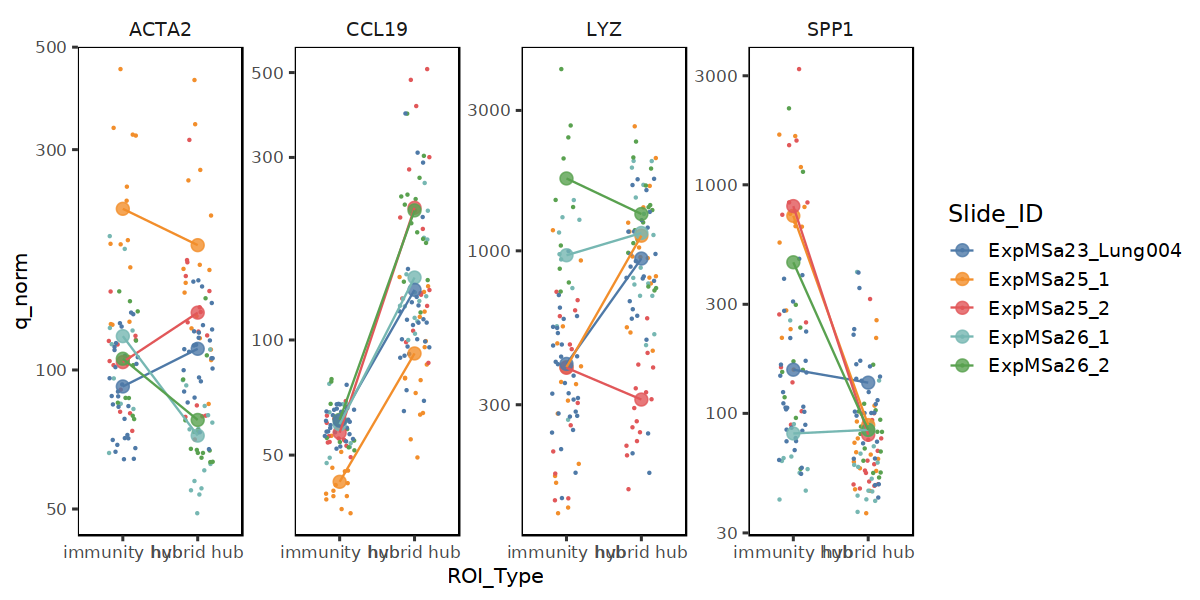

In [4]:
fig.size(5, 10)
plt_df <- geomx_df[
    FeatureName %in% c('ACTA2', 'LYZ', 'CCL19', 'SPP1') 
]

ggplot(plt_df, aes(ROI_Type, q_norm, color = Slide_ID)) + 
    geom_jitter(height = 0, width = .2, size = .2) + 
    geom_point(
        data = plt_df[, .(q_norm = mean(q_norm)), by = .(ROI_Type, Slide_ID, FeatureName)], 
        size = 3, alpha = .8
    ) + 
    # geom_jitter(height = 0, width = .2) + 
    geom_line(
        data = plt_df[, .(q_norm = mean(q_norm)), by = .(ROI_Type, Slide_ID, FeatureName)], 
        aes(group = Slide_ID)
    ) + 
    scale_y_log10() + 
    facet_wrap(~FeatureName, nrow = 1, scales = 'free_y') + 
    scale_color_tableau() + 
    NULL


In [5]:
geomx_fc = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/geomx/allsamples_immunityhub_vs_hybridhub_20221126.csv') %>% 
    subset(!is.na(FC))


In [6]:
table(geomx_fc$FDR < .05)


FALSE  TRUE 
  353   719 

In [7]:
geomx_fc %>% 
    arrange(sign(FC) * log(p_value))

Gene,p_value,FC,Significance,FDR,pi
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CCL19,1.339584e-36,1.2768340,35.87303,1.436034e-33,45.803905
CXCR4,2.170281e-27,0.8557776,26.66348,1.163271e-24,22.818011
JAK3,1.206008e-25,0.3668510,24.91865,4.309467e-23,9.141432
LTB,1.402994e-23,0.5048155,22.85294,3.760025e-21,11.536521
CYFIP2,3.858102e-23,0.3102730,22.41363,8.271772e-21,6.954343
ZAP70,3.909629e-22,0.3635887,21.40786,6.985204e-20,7.783658
TRBC1/2,8.642634e-22,0.7055848,21.06335,1.323558e-19,14.861983
CDKN1B,1.577957e-21,0.3141276,20.80190,2.114462e-19,6.534452
CCND2,7.859007e-21,0.2745061,20.10463,8.518577e-19,5.518845


## vigzen

In [8]:
obj = readRDS('lung_n4/grid/obj_hubs.rds')

In [9]:
names(obj)

[1] "meta_data" "counts"

In [10]:
obj$counts[1:5, 1:5]

,1,2,3,4,5
ACE,4131,0,67,1,1
ACKR1,1496,0,10,0,1
ACKR2,808,0,12,0,0
ACKR3,7100,2,49,1,0
ACKR4,1163,0,18,0,0


In [11]:
head(obj$meta_data)

Registered S3 method overwritten by 'geojson':
  method        from     
  print.geojson geojsonsf



,library,hubType,ID,ntiles,X,Y,area,shape
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<GEOMETRY>
1,Sample05,tumor,1,6381,7156.300,2177.3111,15874262.765,MULTIPOLYGON (((3800.149 18...
2,Sample05,tumor,2,1,8286.479,941.4254,2500.000,POLYGON ((8259.615 925.9153...
3,Sample05,tumor,3,57,10452.114,2271.2108,142500.018,MULTIPOLYGON (((10274.43 22...
4,Sample05,tumor,4,1,10301.298,2383.8630,2500.000,POLYGON ((10274.43 2368.353...
5,Sample05,tumor,5,2,10583.372,1988.3559,5000.001,POLYGON ((10569.94 1980.601...
6,Sample05,tumor,6,27,10906.241,1136.1631,67500.009,POLYGON ((10704.26 1065.506...


## genes

In [12]:
genes_common = intersect(rownames(obj$counts), geomx_fc$Gene)
length(genes_common)


[1] 177

In [13]:
genes_common

[1] "ACTA2"     "ANXA1"     "AXL"       "BATF"      "BIRC3"     "C1QA"     
  [7] "C1QB"      "CCL13"     "CCL18"     "CCL19"     "CCL2"      "CCL21"    
 [13] "CCL4"      "CCL5"      "CCL8"      "CCND1"     "CCR4"      "CCR5"     
 [19] "CCR7"      "CD14"      "CD163"     "CD19"      "CD2"       "CD247"    
 [25] "CD27"      "CD274"     "CD34"      "CD38"      "CD3D"      "CD3E"     
 [31] "CD4"       "CD40"      "CD69"      "CD7"       "CD74"      "CD79A"    
 [37] "CD8A"      "COL1A2"    "COL3A1"    "CPA3"      "CSF1"      "CSF1R"    
 [43] "CSF2RB"    "CSF3R"     "CTLA4"     "CXCL1"     "CXCL10"    "CXCL11"   
 [49] "CXCL12"    "CXCL13"    "CXCL14"    "CXCL16"    "CXCL2"     "CXCL3"    
 [55] "CXCL5"     "CXCL8"     "CXCL9"     "CXCR4"     "DUSP6"     "EGR1"     
 [61] "FAP"       "FAS"       "FLT3LG"    "FN1"       "FOS"       "GAS1"     
 [67] "GBP1"      "GBP4"      "GNLY"      "GZMA"      "GZMK"      "HAVCR2"   
 [73] "HCK"       "HIF1A"     "HLA-C"     "HLA-DRA"   "HLA-E"     "HSPA1A"   
 [79] "ICAM1"     "ID2"       "IDO1"      "IFNAR2"    "IFNGR1"    "IFNGR2"   
 [85] "IGFBP3"    "IL18"      "IL1B"      "IL1R1"     "IL1RAP"    "IL1RN"    
 [91] "IL2RA"     "IL2RB"     "IL2RG"     "IL32"      "IL6"       "IL6R"     
 [97] "IL7R"      "INHBA"     "IRF8"      "ISG15"     "ITGA1"     "ITGA5"    
[103] "ITGAX"     "ITGB7"     "JAG1"      "JUN"       "JUNB"      "KDR"      
[109] "KLRG1"     "LAG3"      "LAMB3"     "LAMP3"     "LEF1"      "LILRB2"   
[115] "LY6E"      "LYZ"       "MARCO"     "MERTK"     "MET"       "MKI67"    
[121] "MMP1"      "MMP9"      "MRC1"      "MS4A1"     "MX1"       "NOTCH1"   
[127] "NOTCH2"    "NOTCH3"    "NT5E"      "PCNA"      "PDCD1LG2"  "PDGFB"    
[133] "PDGFRA"    "PDGFRB"    "PDPN"      "PECAM1"    "PRDM1"     "PRF1"     
[139] "PSMB8"     "PSMB9"     "PTPRC"     "RORA"      "S100A8"    "S100A9"   
[145] "SELL"      "SERPINA1"  "SFRP2"     "SMARCA4"   "SOD2"      "SPP1"     
[151] "SPRY4"     "STAT1"     "STING1"    "STMN1"     "TAP1"      "TCF7"     
[157] "TGFB1"     "TGFB3"     "TGFBR1"    "TGFBR2"    "THY1"      "TIGIT"    
[163] "TNFRSF13B" "TNFRSF1A"  "TNFRSF1B"  "TNFRSF25"  "TNFRSF9"   "TNFSF13B" 
[169] "TOP2A"     "TOX"       "TRAC"      "UBE2C"     "VCAM1"     "VCAN"     
[175] "VEGFA"     "VEGFB"     "VEGFC"

# Diff Exp stats

## geomx

### lmer

In [14]:
# genes_use <- geomx_df[, sum(above_LOQ), by = FeatureName][V1 >= 3, FeatureName]
# # genes_use = genes_common

# foo = function(data_df) {
#     h0 = lmer(y ~ 1 + (1 + ROI_Type|Slide_ID), data_df, REML = FALSE)
#     h1 = lmer(y ~ 1 + ROI_Type + (1 + ROI_Type|Slide_ID), data_df, REML = FALSE)
#     beta = fixef(h1)[['ROI_Typehybrid hub']]
#     pval = anova(h0, h1)['h1', 'Pr(>Chisq)']
#     data.table(beta = beta, pval = pval)
    
# }

# res_geomx = geomx_df[
#     FeatureName %in% genes_use, foo(.SD), by = FeatureName
# ][
#     , fdr := p.adjust(pval, 'BH')
# ][
#     order(-beta)
# ]


In [15]:
# table(res_geomx$fdr < .05)

In [16]:
# res_geomx[order(sign(beta) * log(pval))] %>% head(10)

In [17]:
# fig.size(5, 8)
# res_geomx %>% 
#     ggplot(aes(beta, -log10(pval))) + 
#         geom_point(aes(color = fdr < .05)) + 
#         scale_color_manual(values = c('black', 'red')) + 
#         NULL


In [18]:
# res_geomx[, z := sign(beta) * abs(qnorm(pval / 2, lower.tail = TRUE))]
# geomx_fc[, z := sign(FC) * abs(qnorm(p_value / 2, lower.tail = TRUE))]

In [19]:
# g = c(
#     res_geomx %>% subset(fdr < .2) %>% arrange(-beta) %>% head(10) %>% with(FeatureName),
#     res_geomx %>% subset(fdr < .2) %>% arrange(beta) %>% head(10) %>% with(FeatureName),
#     res_geomx %>% subset(fdr < .2) %>% arrange(-z) %>% head(10) %>% with(FeatureName),
#     res_geomx %>% subset(fdr < .2) %>% arrange(z) %>% head(10) %>% with(FeatureName)
# ) %>% 
# unique()


# fig.size(5, 8)
# res_geomx %>% 
#     ggplot(aes(beta, -log10(pval))) + 
#         geom_point(
#             size = .5,
#             alpha = .3
#         ) + 
#         geom_point(
#             data = . %>% subset(FeatureName %in% g),
#             size = .5,
#             color = 'red'
#         ) + 
#         geom_text_repel(
#             data = . %>% subset(FeatureName %in% g),
#             aes(label = FeatureName),
#             box.padding = .5,
#             max.overlaps = Inf
#         ) + 
#         NULL


### compare to prev

Fold changes are the same but signifance is different. 

In [20]:
# fig.size(5, 8)
# inner_join(res_geomx, geomx_fc, by = c('FeatureName' = 'Gene'), suffix = c('_new', '_old')) %>% 
#     # ggplot(aes(z_new, z_old)) + 
#     ggplot(aes(beta, FC)) + 
#         geom_abline() + 
#         geom_hline(yintercept = 0, linetype = 2) + 
#         geom_vline(xintercept = 0, linetype = 2) + 
#         geom_point() + 
#         labs(x = 'Slope in RE', y = 'No slope in RE') + 
#         NULL


In [21]:
# fig.size(5, 8)
# inner_join(res_geomx, geomx_fc, by = c('FeatureName' = 'Gene'), suffix = c('_new', '_old')) %>% 
#     ggplot(aes(z_new, z_old)) + 
#     # ggplot(aes(beta, FC)) + 
#         geom_abline() + 
#         geom_hline(yintercept = 0, linetype = 2) + 
#         geom_vline(xintercept = 0, linetype = 2) + 
#         geom_point() + 
#         labs(x = 'Slope in RE', y = 'No slope in RE') + 
#         NULL


In [22]:
# res[FeatureName %in% genes_common]


## vizgen

In [23]:
library(presto)
library(lme4)
library(furrr)
library(future)
library(arm)

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:patchwork’:

    area


The following object is masked from ‘package:dplyr’:

    select


The following object is masked from ‘package:spatstat.geom’:

    area



arm (Version 1.13-1, built: 2022-8-25)


Working directory is /n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish



Attaching package: ‘arm’


The following object is masked from ‘package:spatstat.geom’:

    rescale


The following object is masked from ‘package:scales’:

    rescale




In [24]:
# pb <- presto::collapse_counts(obj$counts[, meta_data$ID], meta_data, c('library', 'region_type', 'hubID'))
# # pb$meta_data$is_hh = 1 * (pb$meta_data$region_type == 'hybrid_hub')
# pb$meta_data$region_type <- factor(pb$meta_data$region_type, c('immune_hub', 'hybrid_hub'))

### Fixed effect

In [74]:
obj$meta_data$logUMI = log(colSums(obj$counts))

In [75]:
# plan(sequential)
plan(multicore)
res_merfish = future_map(genes_common, function(gene_test) {
    # data_df = cbind(st_drop_geometry(obj$meta_data), y = obj$counts[gene_test, ]) 
    # data_df = cbind(obj$meta_data, y = obj$counts[gene_test, ]) 
    data_df = cbind(st_drop_geometry(obj$meta_data), y = obj$counts[gene_test, ]) %>% 
        subset(hubType %in% c('hybrid_hub', 'immune_hub')) %>% 
        dplyr::mutate(hubType = factor(hubType, c('immune_hub', 'hybrid_hub')))
    
    tryCatch({
        h0 = glmer(
            y ~ 1 + (1 + hubType | library) + offset(logUMI), 
            data_df, 'poisson'
        )
        h1 = glmer(
            y ~ 1 + hubType + (1 + hubType | library) + offset(logUMI), 
            data_df, 'poisson'
        )
        beta = fixef(h1)[['hubTypehybrid_hub']]
        pval = anova(h0, h1)['h1', 'Pr(>Chisq)']
        data.table(gene = gene_test, beta = beta, pval = pval)
    }, error = function(e) {
        message(glue('Failed on {gene_test}'))
        data.table(gene = gene_test, beta = NA, pval = NA)
    })
}) %>% 
    rbindlist()


boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



In [29]:
# plan(multicore)
# res_merfish = future_map(genes_common, function(gene_test) {
#     data_df = cbind(pb$meta_data, y = pb$counts_mat[gene_test, ])    
#     h0 = glmer(
#         y ~ 1 + (1 + region_type | library) + offset(logUMI), 
#         data_df, 'poisson'
#     )
#     h1 = glmer(
#         y ~ 1 + region_type + (1 + region_type | library) + offset(logUMI), 
#         data_df, 'poisson'
#     )
#     beta = fixef(h1)[['region_typehybrid_hub']]
#     pval = anova(h0, h1)['h1', 'Pr(>Chisq)']
#     data.table(gene = gene_test, beta = beta, pval = pval)
# }) %>% 
#     rbindlist()

In [79]:
res_merfish$fdr <- p.adjust(res_merfish$pval, 'BH')
head(res_merfish)

gene,beta,pval,fdr,logFC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ACTA2,-0.1891726,0.418667920,0.50070420,-0.2729184
ANXA1,-0.7158425,0.002115722,0.02340518,-1.0327424
AXL,-0.2821548,0.089553942,0.14027476,-0.4070634
BATF,0.3048547,0.039227024,0.07489613,0.4398124
BIRC3,0.2419706,0.103205677,0.15613167,0.3490897
C1QA,-0.1403948,0.023550018,0.05392346,-0.2025469


In [77]:
# res_merfish %>% 
#     arrange(fdr)

In [80]:
res_merfish <- res_merfish %>% 
    dplyr::mutate(
        logFC = sign(beta) * log2(exp(abs(beta))),
    ) 
res_merfish %>% 
    subset(gene == 'CCL19')


gene,beta,pval,fdr,logFC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
CCL19,1.628037,0.005649348,0.02942039,2.34876


### Random effect

In [33]:
# system.time({
#     suppressWarnings({
#         presto_res <- presto.presto(
#             # y ~ 1 + region_type + (1 + region_type|library) + offset(logUMI), 
#             y ~ 1 + (1|region_type) + (1|region_type:library) + (1|library) + offset(logUMI), 
#             pb$meta_data, 
#             pb$counts_mat,
#             size_varname = 'logUMI', 
#             effects_cov = c('region_type'),
#             # features = c('CCL19', 'CXCR4'), 
#             features = genes_common, 
#             # effects_cov = c('cluster', 'cluster:library', 'library'),
#             ncore = 20, 
#             min_sigma = .05, ## to avoid numerical instability from REs with 0 variance 
#             family = 'poisson',
#             nsim = 1000
#         ) 
#     })
# })


# contrasts_mat <- make_contrast.presto(presto_res, 'region_type')
# res_merfish <- contrasts.presto(presto_res, contrasts_mat, one_tailed = TRUE) %>% 
#     dplyr::mutate(region_type = contrast) %>% 
#     dplyr::mutate(
#         ## convert stats to log2 for interpretability 
#         logFC = sign(beta) * log2(exp(abs(beta))),
#         SD = log2(exp(sigma)),
#         zscore = logFC / SD
#     ) %>% 
#     dplyr::select(region_type, feature, logFC, SD, zscore, pvalue) %>% 
#     subset(region_type == 'hybrid_hub') %>% 
#     arrange(pvalue)


# head(res_merfish)

# res_merfish %>% subset(feature == 'CCL19')

## Compare

In [87]:
plt_df <- inner_join(
    dplyr::select(res_merfish, gene, logFC, fdr = fdr), ## FE
    # dplyr::select(res_merfish, gene = feature, logFC, zscore, padj = pvalue), ## RE
    # dplyr::select(res_geomx, gene = FeatureName, logFC = beta, padj = fdr), 
    dplyr::select(geomx_fc, gene = Gene, logFC = FC, fdr = FDR), 
    by = 'gene', 
    suffix = c('_merfish', '_geomx')
)


In [82]:
# plt_df %>% arrange(-logFC_merfish * logFC_geomx)

In [83]:
# plt_df %>% 
#     subset(padj_merfish < .05 | padj_geomx < .05) %>% 
#     arrange(logFC_merfish * logFC_geomx)

In [88]:
head(plt_df)

gene,logFC_merfish,fdr_merfish,logFC_geomx,fdr_geomx
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ACTA2,-0.2729184,0.50070420,-0.07729665,3.680631e-01
ANXA1,-1.0327424,0.02340518,-0.53127550,5.657196e-16
AXL,-0.4070634,0.14027476,-0.25259853,2.700139e-10
BATF,0.4398124,0.07489613,0.13655894,1.640906e-07
BIRC3,0.3490897,0.15613167,0.09691654,1.895061e-01
C1QA,-0.2025469,0.05392346,-0.43088797,9.445541e-05


In [93]:
head(plt_df)

gene,logFC_merfish,fdr_merfish,logFC_geomx,fdr_geomx
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ACTA2,-0.2729184,0.50070420,-0.07729665,3.680631e-01
ANXA1,-1.0327424,0.02340518,-0.53127550,5.657196e-16
AXL,-0.4070634,0.14027476,-0.25259853,2.700139e-10
BATF,0.4398124,0.07489613,0.13655894,1.640906e-07
BIRC3,0.3490897,0.15613167,0.09691654,1.895061e-01
C1QA,-0.2025469,0.05392346,-0.43088797,9.445541e-05


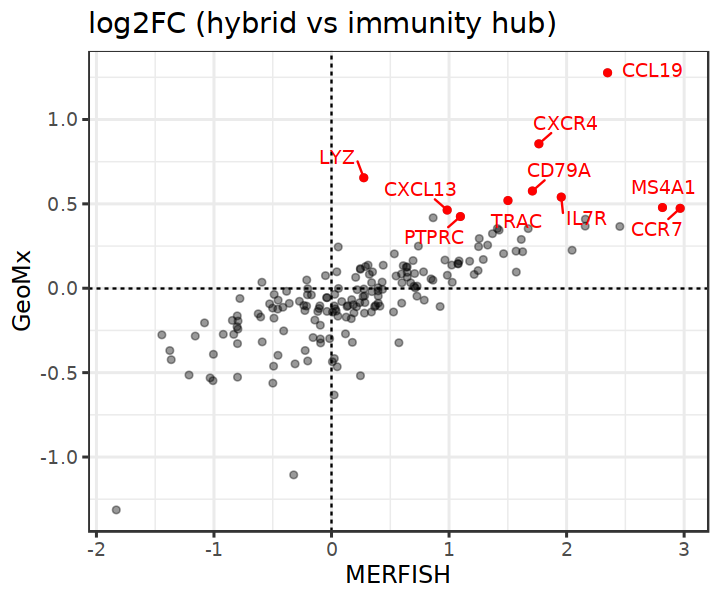

In [98]:
## Choose top 10 genes from GeoMx
genes_highlight = plt_df[fdr_geomx < .01][order(-logFC_geomx)][1:10, gene]


set.seed(42L)
fig.size(5, 6)
# ggplot(plt_df, aes(zscore, z)) + 
# genes_highlight <- c('LYZ', 'SPP1', 'C1QB', 'C1QA', 'CD14', 'CD163')
# genes_highlight <- c('CXCR4', 'SPP1', 'CCL19', 'CXCL9', 'CXCL10', 'CXCL11', 'CCR7', 'CXCR4')
ggplot(plt_df, aes(logFC_merfish, logFC_geomx)) + 
    # geom_abline() + 
    # geom_smooth(method = 'lm', se = FALSE, color = 'black') + 
    geom_hline(yintercept = 0, linetype = 2) + 
    geom_vline(xintercept = 0, linetype = 2) + 
    geom_point(alpha = .4) + 
    # geom_smooth(method = 'lm') + 
    labs(
        title = 'log2FC (hybrid vs immunity hub)',
        x = 'MERFISH', y = 'GeoMx'
    ) +
    scale_color_manual(values = c('black', 'red')) + 
    geom_point(
        data = . %>% subset(gene %in% genes_highlight),
        color = 'red'
    ) + 
    geom_text_repel(
        data = . %>% subset(gene %in% genes_highlight),
        aes(label = gene), 
        color = 'red',
        # min.segment.length = 10
        box.padding = .5
    ) + 
    guides(color = 'none') + 
    theme_bw(base_size = 14) + 
    NULL


# Cache

In [99]:
fwrite(plt_df, 'tables/geomx_vizgen_comparison.csv')
